In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

import asyncio
import json
import pickle
import re
import time
from glob import glob
from pathlib import Path
from urllib import request

import aiohttp
import pandas as pd
import unidecode
from tqdm.autonotebook import tqdm

from nlp_assemblee.scrapping.api import CPCApi
from nlp_assemblee.scrapping.fetch_data_from_api import interventions_of_group, main

In [5]:
# apidep_2007 = CPCApi(legislature="2007-2012")
apidep_2012 = CPCApi(legislature="2012-2017")
apidep_2017 = CPCApi(legislature="2017-2022")
apidep_2022 = CPCApi()

In [33]:
# urls_2012 = await apidep_2012.get_all_interventions_urls(
#     all_pages=False, sort=0, count=500,
#     page=1, verbose=True, max_interventions=1000,
#     save="../data/interventions_urls_by_deputies.json"
# )

In [19]:
last_ints_2017 = await apidep_2017.get_last_int(save="../data/last_ints.json")

In [24]:
api = apidep_2017
tmp = await api.get_deputy_interventions_list(
    dep_name="Cédric Roussel",
    count=500,
    max_interventions=1000,
    last_int=last_ints_2017["Cédric Roussel"],
)

In [27]:
async def get_int_urls_resp(api, dep_name, last_int):
    for attempt in range(10):
        try:
            tmp = await api.get_deputy_interventions_list(
                dep_name=dep_name,
                count=500,
                max_interventions=1000,
                last_int=last_int,
            )
        except Exception as e:
            print(dep_name, e)
            time.sleep(60)
        else:
            return tmp
    else:
        return None


async def get_int_urls(api, last_ints):
    urls = {}
    deps = api.deputies

    tasks = []
    for dep in deps:
        tasks.append(asyncio.ensure_future(get_int_urls_resp(api, dep, last_ints[dep])))

    responses = await asyncio.gather(*tasks)

    for dep, resp in zip(deps, responses):
        urls[dep] = resp

    return urls

In [ ]:
# api = apidep_2017
# urls_2017 = {}
# urls = urls_2017
# last_ints = last_ints_2017

# deps = api.deputies

# for dep in tqdm(deps):
#     try:
#         tmp = await api.get_deputy_interventions_list(
#             dep_name=dep,
#             count=500,
#             max_interventions=1000,
#             last_int=last_ints[dep],
#         )
#         urls[dep] = tmp
#     except Exception as e:
#         print(e)
#         time.sleep(60)

In [6]:
tt = apidep_2017.fetch_urls_dep(
    "Cédric Roussel", all_pages=False, max_interventions=1000, count=500, sort=0, page=1
)

In [39]:
def get_all_urls(
    api, all_pages=False, max_interventions=1000, count=500, sort=0, page=1, save="./data"
):
    deps = api.deputies
    slugs = [api.deputies_df[api.deputies_df["nom"] == dep]["slug"].values[0] for dep in deps]
    files = glob(f"{save}/{api.legislature_name}/urls/*.json")
    files = [file.split("/")[-1].split(".")[0].replace("+", "-") for file in files]
    idx = [i for i, slug in enumerate(slugs) if slug not in files]
    deps = [deps[i] for i in idx]
    slugs = [slugs[i] for i in idx]

    urls = {}

    pbar = tqdm(deps)
    for dep in pbar:
        try:
            urls[dep] = api.fetch_urls_dep(
                dep,
                all_pages=all_pages,
                max_interventions=max_interventions,
                count=count,
                sort=sort,
                page=page,
                save=save,
            )
        except Exception as e:
            print(dep, e)
            time.sleep(60)
    return urls

In [21]:
api = apidep_2017
deps = api.deputies
slugs = [api.deputies_df[api.deputies_df["nom"] == dep]["slug"].values[0] for dep in deps]
files = glob(f"../data/{api.legislature_name}/urls/*.json")
files = [file.split("/")[-1].split(".")[0].replace("+", "-") for file in files]

idx = [i for i, slug in enumerate(slugs) if slug not in files]
deps = [deps[i] for i in idx]
slugs = [slugs[i] for i in idx]


urls = {}

pbar = tqdm(deps)
for dep in pbar:
    try:
        urls[dep] = api.fetch_urls_dep(
            dep,
            all_pages=False,
            max_interventions=1000,
            count=500,
            sort=0,
            page=1,
            save="../data",
        )
    except Exception as e:
        print(dep, e)
        time.sleep(60)

  0%|          | 0/659 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [40]:
urls_2017 = get_all_urls(
    apidep_2017, all_pages=False, max_interventions=500, count=500, sort=0, page=1, save="../data"
)

  0%|          | 0/343 [00:00<?, ?it/s]

In [48]:
apidep_2022.deputies_df[apidep_2022.deputies_df.nom.str.contains("Emeline")]

,id,nom,nom_de_famille,prenom,sexe,date_naissance,lieu_naissance,num_deptmt,nom_circo,num_circo,...,groupe_sigle,parti_ratt_financier,anciens_mandats,profession,place_en_hemicycle,slug,nb_mandats,mandat_fin,ancien_depute,legislature
91,92,Emeline K/Bidi,K/Bidi,Emeline,F,1987-05-13,Saint-Denis (Réunion),974,Réunion,4,...,GDR,Progrès-974,[{'mandat': '22/06/2022 / / '}],Avocate,578,emeline-k-bidi,0,NaN,NaN,last


In [41]:
urls_2022 = get_all_urls(
    apidep_2022, all_pages=False, max_interventions=500, count=500, sort=0, page=1, save="../data"
)

  0%|          | 0/599 [00:00<?, ?it/s]

Emeline K/Bidi [Errno 2] No such file or directory: '../data/last/urls/emeline+k/bidi.json'


In [42]:
urls_2012 = get_all_urls(
    apidep_2012, all_pages=False, max_interventions=100, count=20, sort=0, page=1, save="../data"
)

  0%|          | 0/648 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [40]:
# urls_2022 = await apidep_2022.get_all_interventions_urls(
#     all_pages=False, sort=0, count=500,
#     page=1, verbose=True, max_interventions=1000,
#     save="../data/interventions_urls_by_deputies.json"
# )

In [3]:
with open("../data/2012-2017/interventions_urls_by_deputies.json", "rb") as f:
    urls_2012 = json.load(f)
with open("../data/2017-2022/interventions_urls_by_deputies.json", "rb") as f:
    urls_2017 = json.load(f)
with open("../data/last/interventions_urls_by_deputies.json", "rb") as f:
    urls_2022 = json.load(f)

In [4]:
len(urls_2022), len(urls_2017), len(urls_2012)

(599, 659, 648)

In [14]:
api = apidep_2012
urls = urls_2012

deps = api.deputies
slugs = [api.deputies_df[api.deputies_df["nom"] == dep]["slug"].values[0] for dep in deps]
files = glob(f"../data/{api.legislature_name}/interventions/*.json")
files = [file.split("/")[-1].split(".")[0] for file in files]

idx = [i for i, slug in enumerate(slugs) if slug not in files]
deps = [deps[i] for i in idx]
slugs = [slugs[i] for i in idx]

for dep, slug in tqdm(zip(deps, slugs)):
    try:
        await api.async_fetch_interventions_of_deputy(
            dep_urls=urls[dep],
            slug_name=slug,
            max_interventions=1000,
            verbose=False,
            save="../data/",
        )
    except Exception as e:
        print(e)
        time.sleep(60)

  0%|          | 0/648 [00:00<?, ?it/s]

In [4]:
urls_files_2017 = glob("../data/2017-2022/urls/*.json")
urls_2017 = {}
for file in urls_files_2017:
    with open(file, "r", encoding="utf-8") as f:
        urls = json.load(f)
    urls_2017[unidecode.unidecode(file.split("/")[-1].split(".")[0]).replace("+", "-")] = urls

In [5]:
api = apidep_2017
urls = urls_2017

deps = api.deputies
slugs = [api.deputies_df[api.deputies_df["nom"] == dep]["slug"].values[0] for dep in deps]
files = glob(f"../data/{api.legislature_name}/interventions/*.json")
files = [file.split("/")[-1].split(".")[0] for file in files]

idx = [i for i, slug in enumerate(slugs) if slug not in files]
deps = [deps[i] for i in idx]
slugs = [slugs[i] for i in idx]

print(f"Fetching {len(idx)} deputies' interventions... Instead of {len(api.deputies)}")

for dep, slug in tqdm(zip(deps, slugs), total=len(idx)):
    try:
        await api.async_fetch_interventions_of_deputy(
            dep_urls=urls[slug],
            slug_name=slug,
            max_interventions=500,
            verbose=False,
            save="../data/",
        )
    except KeyError as e:
        print(dep, "KeyError")
    except Exception as e:
        print(dep, e)
        time.sleep(15)

Fetching 635 deputies' interventions... Instead of 659


  0%|          | 0/635 [00:00<?, ?it/s]

[Errno 104] Connection reset by peer

'claire-o-petit'


'christine-cloarec'
'm-jid-el-guerrab'

'pierre-morel-a-l-huissier'
'loic-prud-homme'
'sandrine-moerch'
Cannot connect to host 2017-2022.nosdeputes.fr:443 ssl:default [None]
[Errno 104] Connection reset by peer
[Errno 104] Connection reset by peer
Cannot connect to host 2017-2022.nosdeputes.fr:443 ssl:default [None]
Server disconnected


In [9]:
files = glob(f"../data/{apidep_2022.legislature_name}/interventions/*.json")

In [11]:
with open(files[0], "r", encoding="utf-8") as f:
    interventions = json.load(f)

In [13]:
interventions

{'start': 1,
 'end': 55,
 'last_result': 55,
 'interventions': [{'id': '7738',
   'nb_commentaires': None,
   'nb_mots': '60',
   'md5': '2b5d38442398687f8ea7d0fb7bef7662',
   'intervention': "<p>La flotte d'avions antifeu constitue un service public indispensable, auquel vous devez donner des moyens nouveaux. Quelle flotte et quels moyens humains prévoyez-vous de déployer contre les incendies ? Envisagez-vous d'implanter de nouvelles bases ?</p><p>Si nous voulons sauver des vies humaines, protéger les pompiers et tenter de préserver notre forêt, il y a urgence !</p>",
   'timestamp': '110',
   'source': 'https://www.assemblee-nationale.fr/16/cri/2021-2022-extra/20221009.asp#2816424',
   'seance_id': '63',
   'section_id': '75',
   'type': 'question',
   'date': '2022-07-19',
   'personnalite_id': None,
   'parlementaire_id': '293',
   'parlementaire_groupe_acronyme': 'LFI',
   'fonction': None,
   'created_at': '2022-07-20 17:59:10',
   'updated_at': '2022-07-20 17:59:10',
   'url_nos

In [10]:
interventions = {}
for file in files:
    with open(files[0], "r", encoding="utf-8") as f:
        interventions = json.load(f)

556

In [ ]:
urls_files_2022 = glob("../data/last/urls/*.json")
urls_2022 = {}
for file in urls_files_2022:
    with open(file, "r", encoding="utf-8") as f:
        urls = json.load(f)
    urls_2022[unidecode.unidecode(file.split("/")[-1].split(".")[0]).replace("+", "-")] = urls

In [ ]:
api = apidep_2022
urls = urls_2022

deps = api.deputies
slugs = [api.deputies_df[api.deputies_df["nom"] == dep]["slug"].values[0] for dep in deps]
files = glob(f"../data/{api.legislature_name}/interventions/*.json")
files = [file.split("/")[-1].split(".")[0] for file in files]

idx = [i for i, slug in enumerate(slugs) if slug not in files]
deps = [deps[i] for i in idx]
slugs = [slugs[i] for i in idx]

print(f"Fetching {len(idx)} deputies' interventions... Instead of {len(api.deputies)}")

for dep, slug in tqdm(zip(deps, slugs), total=len(idx)):
    try:
        await api.async_fetch_interventions_of_deputy(
            dep_urls=urls[slug],
            slug_name=slug,
            max_interventions=500,
            verbose=False,
            save="../data/",
        )
    except KeyError as e:
        print(dep, "KeyError")
    except Exception as e:
        print(dep, e)
        time.sleep(15)

In [4]:
async def fetch_all_interventions(api, urls, save="./data/", max_interventions=500):
    deps = api.deputies
    slugs = [api.deputies_df[api.deputies_df["nom"] == dep]["slug"].values[0] for dep in deps]
    files = glob(f"{save}/{api.legislature_name}/interventions/*.json")
    files = [file.split("/")[-1].split(".")[0] for file in files]

    idx = [i for i, slug in enumerate(slugs) if slug not in files]
    deps = [deps[i] for i in idx]
    slugs = [slugs[i] for i in idx]

    print(f"Fetching {len(idx)} deputies' interventions... Instead of {len(api.deputies)}")

    for dep, slug in tqdm(zip(deps, slugs), total=len(idx)):
        # for attempt in range(10):
        try:
            await api.async_fetch_interventions_of_deputy(
                dep_urls=urls[dep],
                slug_name=slug,
                max_interventions=max_interventions,
                verbose=False,
                save=save,
            )
        except Exception as e:
            print(e)
            time.sleep(60)
        #     else:
        #         break
        # else:
        #     print(f"Failed to fetch {dep} after 10 attempts")
        #     break

{'start': 1,
 'end': 500,
 'last_result': 517,
 'interventions': [{'id': '1081',
   'nb_commentaires': None,
   'nb_mots': '163',
   'md5': 'b46186538f62ec7cb931d2d76e761760',
   'intervention': "<p>Le groupe Les Républicains va évidemment repousser ces amendements. Contrairement à leurs auteurs, nous demandons une prorogation de l'état d'urgence bien plus longue, au minimum jusqu'à l'adoption d'une loi sur la sécurité intérieure. Démonstration a été faite, notamment par notre collègue M. Philippe Gosselin, que cette future loi ne sera jamais adoptée avant le 1er novembre. Il faudrait donc une prorogation plus longue.</p><p>À l'attention de certains de nos collègues, je ferais remarquer que l'état d'urgence n'a jamais empêché des manifestations de se produire dans notre pays. Nous nous sommes d'ailleurs insurgés contre des rassemblements qui ont eu lieu pendant une période assez longue place de la République à Paris : ceux du fameux mouvement Nuit debout – et couchés le jour. Ces perso
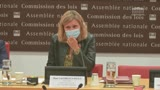

In [10]:
dep = "sebastien huyghe"
t = await apidep_2017.async_fetch_interventions_of_deputy(
    urls_2017[dep],
    slug_name=dep.replace(" ", "-"),
    save="../data/",
    max_interventions=500,
    verbose=False,
)

In [6]:
await fetch_all_interventions(apidep_2017, urls_2017, save="../data/", max_interventions=500)

Fetching 635 deputies' interventions... Instead of 659


  0%|          | 0/635 [00:00<?, ?it/s]

'Anne-Christine Lang'


In [16]:
apidep_2012.deputies_df.to_pickle("../data/2012-2017/deputies.pkl")

In [14]:
apidep_2022.deputies_df.to_pickle("../data/last/deputies.pkl")

In [ ]:
with open("../data/last/interventions_urls_by_deputies.json", "rb") as f:
    urls_2022 = json.load(f)

await apidep_2022.async_fetch_all_interventions(urls_2022, save="../data/")